In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from pymatgen import Structure, Lattice
from pymatgen.core import periodic_table
from pymatgen.analysis import ewald
%run read_struct_get_ewald.ipynb
%run read_struct_get_bond.ipynb
%run read_struct_get_coordination.ipynb
%run read_struct_get_coulomb.ipynb
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import ShuffleSplit, cross_val_score, train_test_split
from sklearn.preprocessing import Imputer

# Machine Learing

In [3]:
train = pd.read_csv('train5.csv')
test = pd.read_csv('test5.csv')

In [342]:
train.head()

,id,spacegroup,number_of_total_atoms,percent_atom_al,percent_atom_ga,percent_atom_in,lattice_vector_1_ang,lattice_vector_2_ang,lattice_vector_3_ang,lattice_angle_alpha_degree,...,cgain,rgain,cgao,rgao,calin,ralin,calo,ralo,cino,rino
0,1,33,80.0,0.6250,0.3750,0.000,9.9523,8.5513,9.1775,90.0026,...,0.000000,inf,-68.138833,1.955995,0.000000,inf,-126.380141,1.953003,0.000000,inf
1,2,194,80.0,0.6250,0.3750,0.000,6.1840,6.1838,23.6287,90.0186,...,0.000000,inf,-74.347543,1.936593,0.000000,inf,-97.805858,1.959401,0.000000,inf
2,3,227,40.0,0.8125,0.1875,0.000,9.7510,5.6595,13.9630,90.9688,...,0.000000,inf,-13.810688,1.869581,0.000000,inf,-57.104462,1.947915,0.000000,inf
3,4,167,30.0,0.7500,0.0000,0.250,5.0036,5.0034,13.5318,89.9888,...,0.000000,inf,0.000000,inf,11.027235,3.316789,-42.805965,2.019747,-16.121344,2.026801
4,5,194,80.0,0.0000,0.6250,0.375,6.6614,6.6612,24.5813,89.9960,...,30.715613,3.556476,-111.422149,2.016436,0.000000,inf,0.000000,inf,-41.095532,2.195004


In [343]:
train.columns

Index(['id', 'spacegroup', 'number_of_total_atoms', 'percent_atom_al',
       'percent_atom_ga', 'percent_atom_in', 'lattice_vector_1_ang',
       'lattice_vector_2_ang', 'lattice_vector_3_ang',
       'lattice_angle_alpha_degree', 'lattice_angle_beta_degree',
       'lattice_angle_gamma_degree', 'formation_energy_ev_natom',
       'bandgap_energy_ev', 'vol', 'n_ga', 'n_al', 'n_in', 'n_o', 'mass_al',
       'mass_ga', 'mass_in', 'mass_o', 'density', 'z_al', 'z_ga', 'z_in',
       'z_o', 'z_tot', 'r_ene', 'k_ene', 'p_ene', 'eta', 'r_gao_ave',
       'r_gao_min', 'r_alo_ave', 'r_alo_min', 'r_ino_ave', 'r_ino_min',
       'inv_r_gao_sum', 'inv2_r_gao_sum', 'inv_r_alo_sum', 'inv2_r_alo_sum',
       'inv_r_ino_sum', 'inv2_r_ino_sum', 'mass_tot', 'inv2_r_sum',
       'inv_r_sum', 'r_min', 'r_mean', 'ngao_mean', 'nalo_mean', 'nino_mean',
       'n_mean', 'coul', 'rmean', 'cgaga', 'rgaga', 'calal', 'ralal', 'cinin',
       'rinin', 'coo', 'roo', 'cgaal', 'rgaal', 'cgain', 'rgain', 'cgao',
    

## Random Forest/Gradient Boosting Regression

In [345]:
features_bandgap = ['mass_al','mass_ga','mass_in','mass_tot','vol','spacegroup', 'percent_atom_al', 'percent_atom_in','density','z_al','z_in','z_tot','inv_r_alo_sum','calo','inv_r_ino_sum','cino','inv2_r_sum','r_min','rmean','nalo_mean','nino_mean','n_mean',
                    'coul','calal','cinin','cgaal','cgain','calin']
features_formation = ['mass_al','mass_ga','mass_in','vol','spacegroup', 'percent_atom_ga','z_ga','inv_r_gao_sum','cgao','r_min','ngao_mean','n_mean',
                      'cgaga','calal','cinin','cgaal','cgain','bandgap_energy_ev']
print('Bandgap features = ', features_bandgap)
print('Formation features = ', features_formation)

Bandgap features =  ['mass_al', 'mass_ga', 'mass_in', 'mass_tot', 'vol', 'spacegroup', 'percent_atom_al', 'percent_atom_in', 'density', 'z_al', 'z_in', 'z_tot', 'inv_r_alo_sum', 'calo', 'inv_r_ino_sum', 'cino', 'inv2_r_sum', 'r_min', 'rmean', 'nalo_mean', 'nino_mean', 'n_mean', 'coul', 'calal', 'cinin', 'cgaal', 'cgain', 'calin']
Formation features =  ['mass_al', 'mass_ga', 'mass_in', 'vol', 'spacegroup', 'percent_atom_ga', 'z_ga', 'inv_r_gao_sum', 'cgao', 'r_min', 'ngao_mean', 'n_mean', 'cgaga', 'calal', 'cinin', 'cgaal', 'cgain', 'bandgap_energy_ev']


Only features that have high correlation with the bandgap/formation energy are chosen.

In [11]:
def ml_regression(train,test,x_feature,y_feature,model,feature_importance=True):
    
    x_train = train[x_feature].values
    y_train = train[y_feature].values
    x_test = test[x_feature].values
    
    print('Defining RFR model...\n')

    model.fit(x_train,y_train)
    score = model.score(x_train,y_train)
    print('Training Score = ', score)

    # CV score
    cv = ShuffleSplit(len(y_train), n_iter=10, test_size=0.1, random_state=0)
    cvscore = cross_val_score(model, x_train, y_train, cv=cv, scoring='r2')
    print('CV Score = ', cvscore)
    print('Mean = ', np.mean(cvscore))
    
    predict = model.predict(x_test)
        
    if feature_importance:
        importances = pd.DataFrame({'feature':x_feature,'importance':np.round(model.feature_importances_,5)})
        importances = importances.sort_values('importance',ascending=False).set_index('feature')
        print(importances)
        importances.plot.bar()
        plt.show()
        
    return model, predict

In [328]:
def submission(predict_bandgap,predict_formation):
    submission = pd.read_csv('sample_submission.csv')
    submission['bandgap_energy_ev'] = predict_bandgap
    submission['formation_energy_ev_natom'] = predict_formation
    submission.to_csv('submission.csv',index=False)

In [12]:
def split_train(train,x_feature,y_feature,model):
    train_2, test_2 = train_test_split(train ,train_size = 0.8)
    x_train_2 = train_2[x_feature].values
    y_train_2 = train_2[y_feature].values
    x_test_2 = test_2[x_feature].values
    y_test_2 = test_2[y_feature].values
    model.fit(x_train_2,y_train_2)
    predict_2 = model.predict(x_test_2)
    plt.scatter(y_test_2,predict_2)
    plt.plot([0,train_2[y_feature].values.max()],[0,train_2[y_feature].values.max()],'--')
    plt.xlabel('Actual')
    plt.ylabel('Predict')
    return plt.show()

Bandap Energy:
Defining RFR model...

Training Score =  0.992877888706
CV Score =  [ 0.95295803  0.95282275  0.95898406  0.94807121  0.93574481  0.95487218
  0.96815333  0.93929541  0.9217323   0.96524798]
Mean =  0.949788205642
                 importance
feature                    
percent_atom_in     0.53842
nalo_mean           0.09617
percent_atom_al     0.06653
spacegroup          0.06173
r_min               0.05373
cgain               0.04591
vol                 0.03453
coul                0.01680
inv2_r_sum          0.01006
mass_tot            0.00937
rmean               0.00664
cino                0.00656
inv_r_ino_sum       0.00569
cgaal               0.00510
density             0.00507
calo                0.00471
z_tot               0.00410
nino_mean           0.00383
cinin               0.00370
calal               0.00355
calin               0.00313
z_in                0.00305
n_mean              0.00294
mass_in             0.00250
inv_r_alo_sum       0.00225
mass_ga        

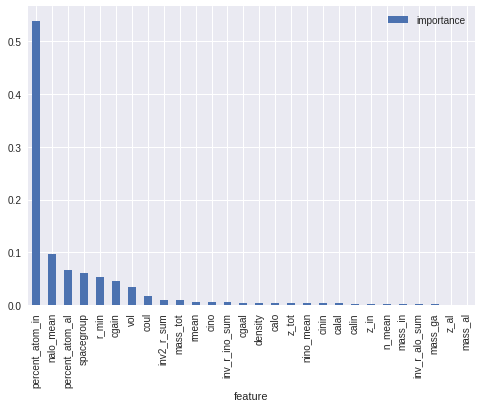

Formation Energy
Defining RFR model...

Training Score =  0.970850426298
CV Score =  [ 0.88184836  0.90577962  0.91129801  0.89087728  0.87324915  0.87026162
  0.93568939  0.87690197  0.87094286  0.91896264]
Mean =  0.893581089719
                   importance
feature                      
bandgap_energy_ev     0.22634
r_min                 0.10788
vol                   0.09128
calal                 0.08898
n_mean                0.07007
cgaal                 0.06187
cinin                 0.05764
cgain                 0.04453
mass_al               0.04044
spacegroup            0.03533
cgao                  0.03307
inv_r_gao_sum         0.03191
cgaga                 0.02941
mass_in               0.02834
ngao_mean             0.02337
percent_atom_ga       0.01977
mass_ga               0.00567
z_ga                  0.00411


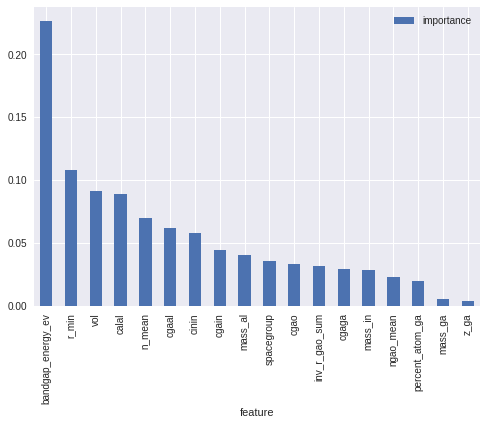

In [348]:
print('Bandap Energy:')
model_bandgap, predict_bandgap = ml_regression(train,test,features_bandgap,'bandgap_energy_ev',RandomForestRegressor(n_estimators=1000))
#model_bandgap, predict_bandgap = ml_regression(train,test,features_bandgap,'bandgap_energy_ev',GradientBoostingRegressor(n_estimators=100))
test['bandgap_energy_ev'] = pd.DataFrame(predict_bandgap)
print('Formation Energy')
#model_formation, predict_formation = ml_regression(train,test,features_formation,'formation_energy_ev_natom',RandomForestRegressor(n_estimators=100))
model_formation, predict_formation = ml_regression(train,test,features_formation,'formation_energy_ev_natom',GradientBoostingRegressor(n_estimators=500))

Prediction scores (R2) on Cross-Validation are 95.0% and 89.4% on bandgap and formation energy.
Notice Gradient Boosting Regression is used on formation energy prediction, because the Random Forest Regression gives high bias on traning score. Predicted bandgap is used as a feature to predict the formation energy due to their high correlation.

In [331]:
submission(predict_bandgap,predict_formation)

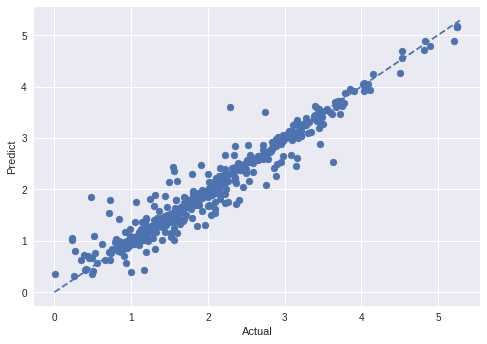

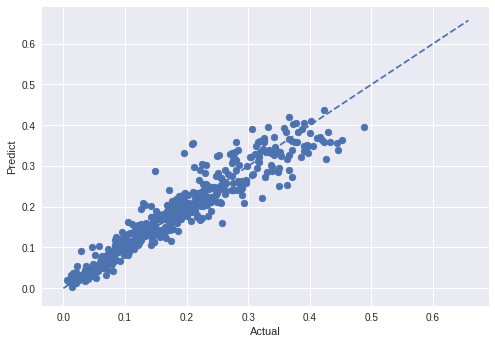

In [353]:
split_train(train,features_bandgap,'bandgap_energy_ev',RandomForestRegressor(n_estimators=1000))
split_train(train,features_formation,'formation_energy_ev_natom',GradientBoostingRegressor(n_estimators=500))